# 1. Introduction

The data at hand is a part of the database of a fundraising organization. The fundraising organization gave you a data dump as of 02/02/2007. They will  use  the  model  you  create to  score  their customer  base in  terms  of  their churn probability.

**Submitted By : _Shriya Jain_**

# 2. Data Prepration

## 2.1 Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score


Data dump is taken of 02/02/2017 

In [5]:
today = datetime.datetime(2007,2,2)

## 2.2 Load Data

In [6]:
communication = pd.read_sas('1 - Data for Churn Modeling/communication.sas7bdat')
communication.info()
communication.duplicated().sum()
communication.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763569 entries, 0 to 763568
Data columns (total 7 columns):
CONTID        763569 non-null object
MEDIUMCODE    763569 non-null object
MNTOPCODE     763569 non-null object
CLASCODE      763569 non-null object
EXTRELNO      763569 non-null object
CONTDIREC     763569 non-null object
CONTDATE      763569 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 46.6+ MB


188

CONTID        763328
MEDIUMCODE        15
MNTOPCODE         24
CLASCODE           9
EXTRELNO       21932
CONTDIREC          2
CONTDATE        3290
dtype: int64

In [7]:
communication.drop_duplicates(inplace=True)
communication.duplicated().sum()

0

In [8]:
extrel = pd.read_sas('1 - Data for Churn Modeling/extrel.sas7bdat')
extrel.info()
extrel.duplicated().sum()
extrel.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26689 entries, 0 to 26688
Data columns (total 4 columns):
EXTRELNO      26689 non-null object
EXRELACTCD    26689 non-null object
EXTRELSTDT    26689 non-null datetime64[ns]
EXRELDATEN    10168 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 1.0+ MB


0

EXTRELNO      18704
EXRELACTCD       17
EXTRELSTDT     2877
EXRELDATEN     2567
dtype: int64

In [9]:
nameaddr = pd.read_sas('1 - Data for Churn Modeling/nameaddr.sas7bdat')
nameaddr.info()
nameaddr.duplicated().sum()
nameaddr.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24186 entries, 0 to 24185
Data columns (total 4 columns):
EXTRELNO      24186 non-null object
NAME1TITLE    23593 non-null object
POSTCODE      24034 non-null object
LANGUACODE    24186 non-null object
dtypes: object(4)
memory usage: 944.8+ KB


0

EXTRELNO      24186
NAME1TITLE        7
POSTCODE       1080
LANGUACODE        3
dtype: int64

In [10]:
payhistory = pd.read_sas('1 - Data for Churn Modeling/payhistory.sas7bdat')
payhistory.info()
payhistory.duplicated().sum()
payhistory.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205720 entries, 0 to 1205719
Data columns (total 6 columns):
PID          1205720 non-null float64
PDATE        1205720 non-null datetime64[ns]
PAMT         1205720 non-null float64
EXTRELNO     1205720 non-null object
PAYTYPECD    1187546 non-null object
STATUS       1205719 non-null object
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 64.4+ MB


0

PID          1205720
PDATE           3483
PAMT            1395
EXTRELNO       16308
PAYTYPECD          4
STATUS             4
dtype: int64

## 2.3 Identifying Active Customers
- Only use data from the independent window to create the predictor variables (Xs)
- End of independent window = 03 December 2005
- Start of dependent window = 01 January 2006
- End of dependent window = 31 December 2006 

An active customer as one with 
- Exrelactcd – Activity code of the donor (FP means active) 
- start date before end of IW 
- end date after start of DW [means he was active during IW]
- missing [means still a donor]



In [11]:
extrel_active = extrel[(extrel['EXRELACTCD']=='FP') & (~(extrel['EXRELDATEN'] <'2006-01-01')) & (extrel['EXTRELSTDT']<'2005-12-03')]

Since active customer has only one activity code
dropping activity code column 

In [12]:
extrel_active = extrel_active.drop(columns=['EXRELACTCD'])

## 2.4 Adding Churn column
Those customers have Activity End Date have churned 

In [13]:
extrel_active['Churn'] = np.where(extrel_active['EXRELDATEN'].isnull(), 0, 1)

In [14]:
extrel_active.nunique()

EXTRELNO      7181
EXTRELSTDT     166
EXRELDATEN     143
Churn            2
dtype: int64

## 2.5 Recency, Frequency, Monetary Value

In [15]:
PAMT_COUNT = pd.DataFrame(payhistory.pivot_table(index='EXTRELNO', values='PAMT', aggfunc='count'))
RECENT_TRANS = pd.DataFrame(payhistory.sort_values(ascending=0, by='PDATE').groupby('EXTRELNO')['PDATE'].nth(0))
PAMT_SUM = payhistory.pivot_table(index='EXTRELNO', values='PAMT', aggfunc='sum')
PAMT_MEAN = payhistory.pivot_table(index='EXTRELNO', values='PAMT', aggfunc='mean')
RECENT_COMM = pd.DataFrame(communication.drop(columns=['CONTID']).sort_values(ascending=0, by='CONTDATE').groupby('EXTRELNO').nth(0))



In [16]:
PAMT_COUNT.columns
RECENT_TRANS.columns
PAMT_SUM.columns
PAMT_MEAN.columns
RECENT_COMM.columns


Index([u'PAMT'], dtype='object')

Index([u'PDATE'], dtype='object')

Index([u'PAMT'], dtype='object')

Index([u'PAMT'], dtype='object')

Index([u'CLASCODE', u'CONTDATE', u'CONTDIREC', u'MEDIUMCODE', u'MNTOPCODE'], dtype='object')

In [18]:
df_RF = pd.concat([PAMT_COUNT,PAMT_SUM,PAMT_MEAN,RECENT_TRANS,RECENT_COMM],axis=1,sort=False)
df_RF = df_RF.reset_index()
df_RF.columns = ['EXTRELNO','PAMT_COUNT','PAMT_SUM','PAMT_MEAN','RECENT_TRANS','CLASCODE','CONTDATE','CONTDIREC','MEDIUMCODE','MNTOPCODE']
df_RF.head()
df_RF.nunique()

,EXTRELNO,PAMT_COUNT,PAMT_SUM,PAMT_MEAN,RECENT_TRANS,CLASCODE,CONTDATE,CONTDIREC,MEDIUMCODE,MNTOPCODE
0,0000019,1.0,9.57,9.570000,1993-12-31,NaN,NaT,NaN,NaN,NaN
1,0000020,158.0,3176.97,20.107405,2007-01-17,CT,2006-08-10,O,CI,CTS
2,0000035,155.0,3168.40,20.441290,2007-01-17,CT,2006-10-03,O,CI,CTS
3,0000042,85.0,1543.03,18.153294,2001-01-23,AN,2001-03-29,O,LE,DIS
4,0000043,229.0,4373.24,19.097118,2003-07-14,ID,2004-01-23,O,LE,TAX


EXTRELNO        22919
PAMT_COUNT        344
PAMT_SUM         9280
PAMT_MEAN       11281
RECENT_TRANS     1898
CLASCODE            8
CONTDATE         2238
CONTDIREC           2
MEDIUMCODE         13
MNTOPCODE          21
dtype: int64

## 2.6 Merging Data

- Active customers data
- Recency Frequency Monetary data
- customers demography data

In [19]:
base_df = pd.merge(pd.merge(extrel_active,df_RF),nameaddr)

In [20]:
base_df.nunique()

EXTRELNO        7181
EXTRELSTDT       166
EXRELDATEN       143
Churn              2
PAMT_COUNT       274
PAMT_SUM        3319
PAMT_MEAN       4480
RECENT_TRANS     354
CLASCODE           6
CONTDATE         221
CONTDIREC          2
MEDIUMCODE        11
MNTOPCODE         18
NAME1TITLE         6
POSTCODE         770
LANGUACODE         2
dtype: int64

## 2.7 Churn per Year

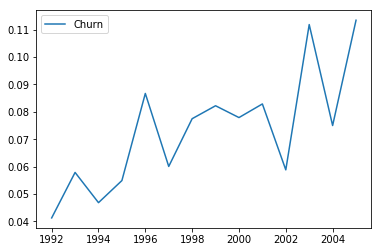

In [21]:
sns.lineplot(data=base_df.pivot_table(index=map(lambda x : x.year, extrel_active['EXTRELSTDT']), values='Churn', aggfunc='mean'))

Churn is increasing every year

## 2.8 Creating Predictor Variables

In [22]:
base_df['RECENCY_DAYS_TRANS'] = map(lambda y : y.days , map(lambda x : x , today - base_df['RECENT_TRANS'] ))
base_df['RECENCY_DAYS_COMM'] = map(lambda y : y.days , map(lambda x : x , today - base_df['CONTDATE'] ))
base_df['REL_DURATION'] = map(lambda z : z.days ,base_df['EXRELDATEN'].fillna(today) - base_df['EXTRELSTDT'])
base_df['STARTYEAR'] =  map(lambda x : x.year, base_df['EXTRELSTDT'])
base_df.head()

,EXTRELNO,EXTRELSTDT,EXRELDATEN,Churn,PAMT_COUNT,PAMT_SUM,PAMT_MEAN,RECENT_TRANS,CLASCODE,CONTDATE,CONTDIREC,MEDIUMCODE,MNTOPCODE,NAME1TITLE,POSTCODE,LANGUACODE,RECENCY_DAYS_TRANS,RECENCY_DAYS_COMM,REL_DURATION,STARTYEAR
0,0026419,1992-03-01,NaT,0,69.0,3155.05,45.725362,2007-01-02,CT,2006-07-19,O,CI,CTS,HM,2600,NL,31.0,198,5451,1992
1,0026430,1992-03-01,2006-01-31,1,146.0,2786.13,19.083082,2005-10-18,AK,2006-03-16,O,LE,DIS,HM,2040,NL,472.0,323,5084,1992
2,0026431,1992-03-01,NaT,0,21.0,3050.61,145.267143,2006-04-28,CT,2006-10-05,O,CI,CTS,FA,8520,NL,280.0,120,5451,1992
3,0026443,1992-03-01,NaT,0,156.0,3109.62,19.933462,2007-01-17,CT,2006-12-14,O,CI,CTS,HM,1652,NL,16.0,50,5451,1992
4,0026444,1992-03-01,NaT,0,157.0,3092.47,19.697261,2007-01-17,CT,2006-06-21,O,CI,CTS,MW,3001,NL,16.0,226,5451,1992


## 2.9 Label Encoding Categorical Variables

In [23]:
base_df.nunique().sort_values()

Churn                    2
LANGUACODE               2
CONTDIREC                2
NAME1TITLE               6
CLASCODE                 6
MEDIUMCODE              11
STARTYEAR               14
MNTOPCODE               18
EXRELDATEN             143
EXTRELSTDT             166
RECENCY_DAYS_COMM      221
CONTDATE               221
PAMT_COUNT             274
RECENT_TRANS           354
RECENCY_DAYS_TRANS     354
REL_DURATION           604
POSTCODE               770
PAMT_SUM              3319
PAMT_MEAN             4480
EXTRELNO              7181
dtype: int64

In [24]:
le_cols = ['LANGUACODE','CONTDIREC','CLASCODE','NAME1TITLE','MEDIUMCODE','MNTOPCODE']

for col in le_cols:
    base_df[col] = LabelEncoder().fit_transform(base_df[col])
    

In [25]:
pd.concat([base_df.dtypes,base_df.isna().sum(),base_df.nunique()],axis=1).sort_values(by=[2])

,0,1,2
Churn,int32,0,2
LANGUACODE,int32,0,2
CONTDIREC,int32,0,2
CLASCODE,int32,0,6
NAME1TITLE,int32,0,7
MEDIUMCODE,int32,0,11
STARTYEAR,int64,0,14
MNTOPCODE,int32,0,18
EXRELDATEN,datetime64[ns],6675,143
EXTRELSTDT,datetime64[ns],0,166


## 2.10 Dropping extra variables
     - 'EXRELDATEN','EXTRELSTDT' data is captured in 'REL_DURATION'
    - 'CONTDATE'data is captured in RECENCY_DAYS_COMM
    - 'RECENT_TRANS'data is captured in RECENCY_DAYS_TRANS

In [26]:
col_drop = ['EXRELDATEN','EXTRELSTDT','CONTDATE','RECENT_TRANS']

base_df = base_df.drop(columns=col_drop)
sorted(base_df.columns)

['CLASCODE',
 'CONTDIREC',
 'Churn',
 u'EXTRELNO',
 u'LANGUACODE',
 'MEDIUMCODE',
 'MNTOPCODE',
 u'NAME1TITLE',
 'PAMT_COUNT',
 'PAMT_MEAN',
 'PAMT_SUM',
 u'POSTCODE',
 'RECENCY_DAYS_COMM',
 'RECENCY_DAYS_TRANS',
 'REL_DURATION',
 'STARTYEAR']

## 2.11 Preparing communication data

In [27]:
pd.DataFrame(communication.pivot_table(index='EXTRELNO', columns='MEDIUMCODE', values='CLASCODE', aggfunc='count')).fillna(0).sum().sort_values(ascending=False)
pd.DataFrame(communication.pivot_table(index='EXTRELNO', columns='MNTOPCODE', values='CLASCODE', aggfunc='count')).fillna(0).sum().sort_values(ascending=False)
pd.DataFrame(communication.pivot_table(index='EXTRELNO', columns='CONTDIREC', values='CLASCODE', aggfunc='count')).fillna(0).sum().sort_values(ascending=False)
pd.DataFrame(communication.pivot_table(index='EXTRELNO', columns='CLASCODE', values='MEDIUMCODE', aggfunc='count')).fillna(0).sum().sort_values(ascending=False)


MEDIUMCODE
CI    446428.0
LE    259529.0
EM     18851.0
RM     14872.0
TE     12165.0
ME      3169.0
MR      2391.0
FF      2365.0
FX      2122.0
CA       760.0
TM       549.0
AF       126.0
AC        28.0
AM        25.0
NA         1.0
dtype: float64

MNTOPCODE
CTS    453671.0
TAX    132285.0
REP     54495.0
CAN     20697.0
ENR     18556.0
ARR     17314.0
INF     14220.0
COR     11918.0
DIS      9693.0
FIN      6834.0
IRE      6439.0
PRA      3314.0
VIS      3087.0
VOL      2679.0
PRO      2145.0
FIC      1965.0
TVS      1095.0
IFF       985.0
ALL       937.0
CAT       701.0
MER       242.0
WEB       105.0
SPO         2.0
TLT         2.0
dtype: float64

CONTDIREC
O    733250.0
I     30131.0
dtype: float64

CLASCODE
CT    458865.0
ID    202882.0
AN     37955.0
RI     23771.0
AK     18303.0
PM     10619.0
RM      8558.0
CM      2304.0
NS       124.0
dtype: float64

Selecting CLASCODE categories and MEDIUMCODE categories with maximum count when grouped by different columns of communication data

In [28]:
MEDIUMCODE_CI_LE = pd.DataFrame(communication.pivot_table(index='EXTRELNO', columns='MEDIUMCODE', values='CLASCODE', aggfunc='count'))[['CI','LE']].fillna(0)
MNTOPCODE_CTS_TAX = pd.DataFrame(communication.pivot_table(index='EXTRELNO', columns='MNTOPCODE', values='CLASCODE', aggfunc='count'))[['CTS','TAX']].fillna(0)
CONTDIREC_O_I = pd.DataFrame(communication.pivot_table(index='EXTRELNO', columns='CONTDIREC', values='CLASCODE', aggfunc='count'))[['O','I']].fillna(0)
CLASCODE_CT_ID = pd.DataFrame(communication.pivot_table(index='EXTRELNO', columns='CLASCODE', values='MEDIUMCODE', aggfunc='count'))[['CT','ID']].fillna(0)


## 2.12 Merging communication data

In [29]:
commmunication2 = pd.concat([MEDIUMCODE_CI_LE,MNTOPCODE_CTS_TAX,CONTDIREC_O_I,CLASCODE_CT_ID],axis=1)
commmunication2.columns = ['MEDIUMCODE_CI','MEDIUMCODE_LE','MNTOPCODE_CTS','MNTOPCODE_TAX','CONTDIREC_O','CONTDIREC_I','CLASCODE_CT','CLASCODE_ID']
commmunication2 = commmunication2.reset_index()
base_df2 = pd.merge(base_df,commmunication2)

In [30]:
base_df2.shape

(7181, 24)

In [31]:
pd.concat([base_df2.dtypes,base_df2.isna().sum(),base_df2.nunique()],axis=1).sort_values(by=[2])

,0,1,2
LANGUACODE,int32,0,2
Churn,int32,0,2
CONTDIREC,int32,0,2
CLASCODE,int32,0,6
NAME1TITLE,int32,0,7
MEDIUMCODE,int32,0,11
STARTYEAR,int64,0,14
MNTOPCODE,int32,0,18
MNTOPCODE_TAX,float64,0,22
CONTDIREC_I,float64,0,33


# 2.13 Missing Value Imputation

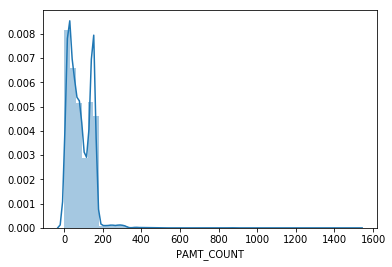

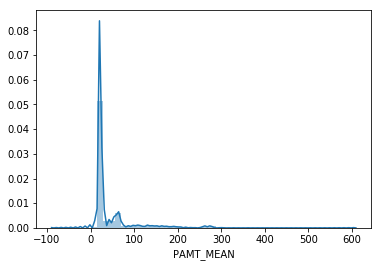

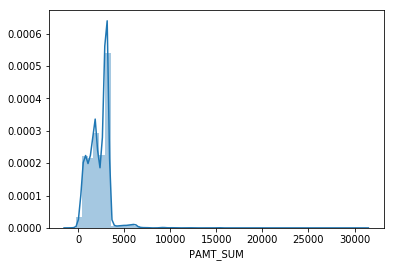

In [34]:
sns.distplot(base_df2.PAMT_COUNT[base_df2.PAMT_COUNT.notna()])
plt.show()
sns.distplot(base_df2.PAMT_MEAN[base_df2.PAMT_MEAN.notna()])
plt.show()
sns.distplot(base_df2.PAMT_SUM[base_df2.PAMT_SUM.notna()])

Since data is skewed and unique values are high using median to impute missing data

In [35]:
base_df2.PAMT_COUNT = base_df2.PAMT_COUNT.fillna(base_df2.PAMT_COUNT.median())
base_df2.PAMT_MEAN = base_df2.PAMT_MEAN.fillna(base_df2.PAMT_MEAN.median())
base_df2.PAMT_SUM = base_df2.PAMT_SUM.fillna(base_df2.PAMT_SUM.median())

Imputing -1 where RECENCY_DAYS_TRANS is null which implies transaction has never been made.

In [36]:
base_df2['RECENCY_DAYS_TRANS'] = base_df2['RECENCY_DAYS_TRANS'].fillna(-1)

POSTCODE has few postcodes containing string or string-number so formatting them and imputing missing values with zero

In [83]:
base_df2['POSTCODE'] = base_df2['POSTCODE'].fillna(0)

def check_int(x):
    try:
        x = int(x)
        return(x)
    except Exception as ex:
        try:
            tmp = ('').join([char for char in list(str(x)) if char.isdigit()])
            x = int(tmp)
            return(x)
        except Exception as ex:
            print('Unexpected Error : '+ex.message,x)
            return(x)
        
base_df2['POSTCODE'] = base_df2['POSTCODE'].apply(lambda x : check_int(x)) 

In [84]:
convert_int_col = ['CLASCODE',
 'CLASCODE_CT',
 'CLASCODE_ID',
 'CONTDIREC',
 'CONTDIREC_I',
 'CONTDIREC_O',
 'Churn',
 u'EXTRELNO',
 u'LANGUACODE',
 'MEDIUMCODE',
 'MEDIUMCODE_CI',
 'MEDIUMCODE_LE',
 'MNTOPCODE',
 'MNTOPCODE_CTS',
 'MNTOPCODE_TAX',
 u'NAME1TITLE',
 'PAMT_COUNT',
 u'POSTCODE',
 'RECENCY_DAYS_COMM',
 'RECENCY_DAYS_TRANS',
 'REL_DURATION',
 'STARTYEAR']
for col in convert_int_col:
    try:
        base_df2[col] = base_df2[col].astype(int)
    except Exception as ex:
        ex.message
        col

Dropping EXTRELNO as it contains unique values for each row and won't be useful for model

In [85]:
base_df2 = base_df2.drop(columns=['EXTRELNO'])

# 3. Building Models

## 3.1 Splitting Data into Train, Validation and Test data

- Divide your data into different time windows. 
- For example:If you have data for 5 years, 
    - Use the first 3 years to train models
    - validate on the 4th year and pick your best model
    - The 5th year’s data will be your hold-out sample for determining out-of-sample accuracy

In [86]:
'Current Year : ',today.year
'Minimum Start Year  : ',base_df2['STARTYEAR'].min()

totalPeriod = today.year - base_df2['STARTYEAR'].min()

train_yr = base_df2['STARTYEAR'].min() + (totalPeriod)*3/5
'Training period : ',[base_df2['STARTYEAR'].min(),train_yr]

validate_yr = train_yr + (totalPeriod)*1/5
'Validation period : ',[train_yr+1,validate_yr]

test_yr = validate_yr + (totalPeriod)*1/5
'Test period : ',[validate_yr+1,test_yr]

train = base_df2[ (base_df2.STARTYEAR <= train_yr)]
validation = base_df2[(base_df2.STARTYEAR > train_yr) & (base_df2.STARTYEAR <= validate_yr)]
test = base_df2[base_df2.STARTYEAR > validate_yr]


('Current Year : ', 2007)

('Minimum Start Year  : ', 1992)

('Training period : ', [1992, 2001])

('Validation period : ', [2002, 2004])

('Test period : ', [2005, 2007])

## 3.2 Splitting Target and Dependent variables

In [87]:
X_train = train.drop(['Churn'], axis=1)
Y_train = train.Churn

X_validation = validation.drop(['Churn'], axis=1)
Y_validation = validation.Churn

X_test = test.drop(['Churn'], axis=1)
Y_test = test.Churn

## 3.3 Scaling data for different models

In [88]:
for data in [X_train,X_validation,X_test] :
    data = data.astype(np.float)
    scaler = StandardScaler()
    data = scaler.fit_transform(data)


## 3.4 Applying Models

- Suuport Vector Machines
    - It is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples.
<br><br> 
- Random Forest Classifier
    - It creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object.
<br><br> 
- Logistic Regression
    - Logistic regression models the probability of the default class of dependent variable
<br><br>     
- Gradient Boost Classifier
    - It repetitively leverage the patterns in residuals and strengthen a model with weak predictions and make it better. Once we reach a stage that residuals do not have any pattern that could be modeled, we can stop modeling residuals (otherwise it might lead to overfitting). Algorithmically, we are minimizing our loss function, such that test loss reach its minima

In [89]:
# Applying different models and storing metrics in scores dataframe

# Evaluates different metrics based on target variable and predicted values
def get_scores(classifiers,**kwargs):
    scores = pd.DataFrame()
    
    for name,classifier in classifiers.items():
        clf = classifier(**kwargs)
        clf.fit(X_train,Y_train)
        
        col = pd.Series()
        types = {'Train' : [Y_train,clf.predict(X_train)],'Validation' : [Y_validation,clf.predict(X_validation)],'Test' : [Y_test,clf.predict(X_test)]}
        for type_name,values in types.items():
            col['Confusion matrix'] = confusion_matrix(values[0],values[1])
            col['Accuracy score'] =accuracy_score(values[0],values[1])
            col['F1 score'] = f1_score(values[0],values[1],average='binary')
            col['ROC AUC Score'] = roc_auc_score(values[0],values[1])
            col['Average Precision score'] = average_precision_score(values[0],values[1])
            col['Recall Score'] = recall_score(values[0],values[1])

            scores[name+'_'+type_name] =  col
    return(scores)

In [90]:
classifiers = {'Support Vector Machines':SVC,\
              'Random Forest Classifier':RFC,\
              'K Neighbors Classifier':KNC,\
              'Logistic Regression':LR,\
              'Gradient Boosting Classifier':GBC}

scores = get_scores(classifiers)
scores = scores.T

C:\Users\Shriya\Software\Anaconda2\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Shriya\Software\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Shriya\Software\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Shriya\Software\Anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWa

## 3.5 Comparing Metrics

**Evaluation Metrics :**
- Accuracy Score
    - Accuracy = TP+TN/TP+FP+FN+TN
<br><br>
- F1 Score
    - F1 Score = 2*(Recall * Precision) / (Recall + Precision)
<br><br>
- ROC AUC Score
    - The Receiver Operating Characteristic (ROC) curve is a plot of the true positive rate (% bads rejected) vs. the false positive rate (% goods rejected) found over a set of predictions.
    - TPR = TP/(TP + FN) 
    - FPR = FP/(FP + TN)
    - (ROC AUC) is just the area under the ROC curve. The higher it is, the better the model is.
<br><br>
- Average Precision Score
    - Precision = TP/TP+FP
<br><br>
- Recall Score
    - Recall = TP/TP+FN

In [91]:
scores.reindex([index for index in scores.index if 'Train' in index]).sort_values(by=scores.columns.tolist()[1:],ascending=[False for item in scores.columns][1:])
scores.reindex([index for index in scores.index if 'Validation' in index]).sort_values(by=scores.columns.tolist()[1:],ascending=[False for item in scores.columns][1:])
scores.reindex([index for index in scores.index if 'Test' in index]).sort_values(by=scores.columns.tolist()[1:],ascending=[False for item in scores.columns][1:])


,Confusion matrix,Accuracy score,F1 score,ROC AUC Score,Average Precision score,Recall Score
Support Vector Machines_Train,"[[5087, 0], [0, 350]]",1,1,1,1,1
Random Forest Classifier_Train,"[[5087, 0], [11, 339]]",0.997977,0.984035,0.984286,0.970595,0.968571
Gradient Boosting Classifier_Train,"[[5085, 2], [12, 338]]",0.997425,0.97971,0.982661,0.962241,0.965714
Logistic Regression_Train,"[[5038, 49], [155, 195]]",0.962479,0.656566,0.773755,0.473766,0.557143
K Neighbors Classifier_Train,"[[5067, 20], [193, 157]]",0.960824,0.595825,0.72232,0.433383,0.448571


,Confusion matrix,Accuracy score,F1 score,ROC AUC Score,Average Precision score,Recall Score
Gradient Boosting Classifier_Validation,"[[1110, 9], [11, 85]]",0.983539,0.894737,0.938687,0.809696,0.885417
Random Forest Classifier_Validation,"[[1112, 7], [13, 83]]",0.983539,0.892473,0.929164,0.808038,0.864583
Logistic Regression_Validation,"[[1100, 19], [47, 49]]",0.945679,0.597561,0.746719,0.406483,0.510417
Support Vector Machines_Validation,"[[1119, 0], [96, 0]]",0.920988,0,0.5,0.0790123,0
K Neighbors Classifier_Validation,"[[719, 400], [33, 63]]",0.643621,0.225403,0.649394,0.116456,0.65625


,Confusion matrix,Accuracy score,F1 score,ROC AUC Score,Average Precision score,Recall Score
Gradient Boosting Classifier_Test,"[[459, 10], [5, 55]]",0.971645,0.88,0.947672,0.785093,0.916667
Random Forest Classifier_Test,"[[465, 4], [18, 42]]",0.958412,0.792453,0.845736,0.673157,0.7
Logistic Regression_Test,"[[458, 11], [24, 36]]",0.933837,0.672897,0.788273,0.504943,0.6
Support Vector Machines_Test,"[[469, 0], [60, 0]]",0.886578,0,0.5,0.113422,0
K Neighbors Classifier_Test,"[[148, 321], [19, 41]]",0.357278,0.194313,0.499449,0.113311,0.683333


**Training Data**
    - SVM has the best scores
**Validation Data**
    - Gradient Boosting Classifier has the best scores
**Test Data**
    - Gradient Boosting Classifier has the best scores
    
_Since Gradient Boosting Classifier has best metrics compared to other models on validation and test data.<br>
**Gradient Boosting Classifier** is the final model selected_

## 3.6 Final Model

**Gradient Boosting Classifier is the final model selected**

In [95]:
scores.reindex(['Gradient Boosting Classifier_Train','Gradient Boosting Classifier_Validation','Gradient Boosting Classifier_Test'])

,Confusion matrix,Accuracy score,F1 score,ROC AUC Score,Average Precision score,Recall Score
Gradient Boosting Classifier_Train,"[[5085, 2], [12, 338]]",0.997425,0.97971,0.982661,0.962241,0.965714
Gradient Boosting Classifier_Validation,"[[1110, 9], [11, 85]]",0.983539,0.894737,0.938687,0.809696,0.885417
Gradient Boosting Classifier_Test,"[[459, 10], [5, 55]]",0.971645,0.88,0.947672,0.785093,0.916667


- Gradient Boosting Classifier has good Recall Score as compared to Precision score for validation and test data.
- Since we are looking for customers who are going to churn we prefer to have **Low False Negative** (FN = Predicted customer won't churn but customer discontinues the service) which is captured in Recall Score. High Recall implies low FN.
- Rather than Precision Score which captures False Positive (FP = Predicted customer would churn but customer continued the service). 

Text(0.5,1,'Confusion matrix for Gradient Boosting Classifier_Train Data')

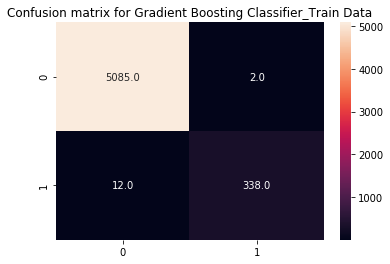

Text(0.5,1,'Confusion matrix for Gradient Boosting Classifier_Validation Data')

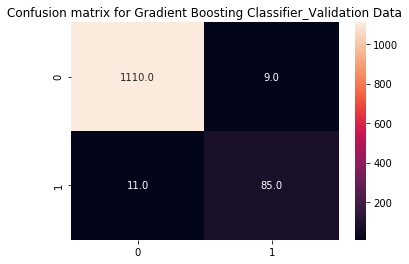

Text(0.5,1,'Confusion matrix for Gradient Boosting Classifier_Test Data')

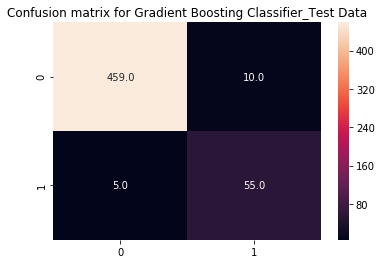

In [96]:
for col in ['Gradient Boosting Classifier_Train','Gradient Boosting Classifier_Validation','Gradient Boosting Classifier_Test']:
    plt.title('Confusion matrix for '+col+' Data')
    sns.heatmap(scores.loc[col,'Confusion matrix'], fmt=".1f",annot=True)
    plt.show()